1. Create a distribution plot for each image set, showing the total sterling value of coins in each image, ignore all coins that are not UK currency

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tensorflow.keras.models import load_model

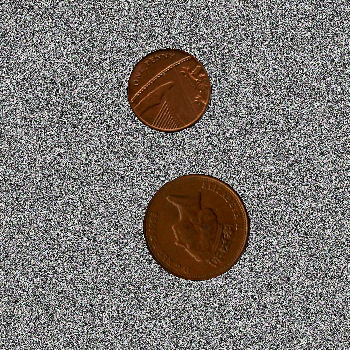

Processing images: 100%|██████████| 800/800 [00:13<00:00, 59.88it/s]


In [12]:
 # datasets folder paths
dataset1_path = "/content/dataset1"
dataset2_path = "/content/dataset2"

# load image paths
dataset1_images = [os.path.join(dataset1_path, f) for f in os.listdir(dataset1_path) if f.endswith((".png"))]
dataset2_images = [os.path.join(dataset2_path, f) for f in os.listdir(dataset2_path) if f.endswith((".png"))]

# load and display one img
image = cv2.imread(dataset1_images[4])
cv2_imshow(image)


# Detect coins
# using watershed segmentation
def detect_coins_with_watershed(image_path, show=False):

    # load an image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return []

    original = img.copy()
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # add Gaussian blur => noise removal
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    # Binary thresholding => turn blurred, grayscale image
    # into a black & white image, based on a threshold => segmentation
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # remove small noise (2 times)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # sure foreground
    # convert binary img into dist map
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # only the most confidence regions of each coin
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # unknown = 0 , background = 1
    markers = markers + 1
    markers[unknown == 255] = 0

    # apply watershed
    markers = cv2.watershed(img, markers)
    # draw red boundaries
    # between coins
    img[markers == -1] = [0, 0, 255]

    coins = []
    for marker_id in np.unique(markers):
      # skip background and unknown regions
        if marker_id in [0, 1]:
            continue
        # create binary mask
        mask = np.uint8(markers == marker_id) * 255
        # find edge of the coin
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
          # rectangle around the coin
            x, y, w, h = cv2.boundingRect(contours[0])
            # keep the coin size
            if 30 < w < 150 and 30 < h < 150:
              # crop the coin
                coin = original[y:y+h, x:x+w]
                coins.append(coin)
                if show:
                  # draw green box around each coin
                    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if show:
        print(f"Watershed detected {len(coins)} coins in {os.path.basename(image_path)}")
        cv2_imshow(img)

    return coins





#new_dataset1 = [detect_coin(dataset1_images[i]) for i in range(len(dataset1_images))]
#new_dataset2 = [detect_coin(dataset2_images[i]) for i in range(len(dataset2_images))]

# combine images from both datasets
all_images = dataset1_images + dataset2_images

all_detected_coins = []
 # (image_path, coin_index)

coin_image_map = []
#  save cropped coins in "cropped_coins"  folder
save_folder = "/content/cropped_coins"
os.makedirs(save_folder, exist_ok=True)

# loop through all images
for image_path in tqdm(all_images, desc="Processing images"):
    coins = detect_coins_with_watershed(image_path)

  # loop through the detected coins
    for idx, coin in enumerate(coins):
        all_detected_coins.append(coin)
        coin_image_map.append((image_path, idx))

        # save cropped coin
        filename = os.path.basename(image_path).replace(".png", f"_coin{idx+1}.png")
        save_path = os.path.join(save_folder, filename)
        cv2.imwrite(save_path, coin)








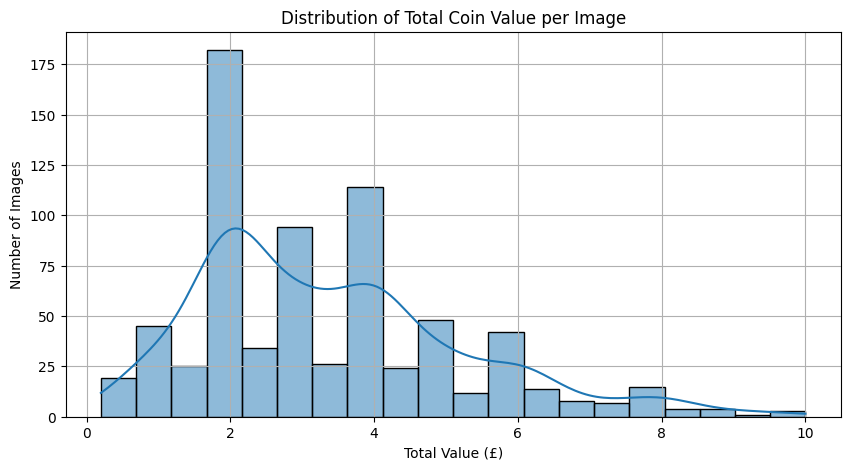

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# map values for UK coins only
coin_values = {
    "1p": 0.01, "2p": 0.02, "5p": 0.05, "10p": 0.10,
    "20p": 0.20, "50p": 0.50, "£1": 1.00, "£2": 2.00
}

# simple classification rules based on size and color
def classify_coin(coin_img):
  # convert to HSV
    hsv = cv2.cvtColor(coin_img, cv2.COLOR_BGR2HSV)
    # get the avg for Hue channel
    avg_color = np.mean(hsv[:, :, 0])
    # get approx diameter
    height, width = coin_img.shape[:2]
    size = max(height, width)

    #  heuristic rules
    if size < 40:
        return "5p"
    elif size < 50:
        return "10p"
    elif size < 60 and avg_color < 20:
        return "1p"
    elif size < 60 and avg_color > 20:
        return "2p"
    elif size < 70:
        return "20p"
    elif size < 80:
        return "50p"
    elif size < 90:
        return "£1"
    elif size >= 90:
        return "£2"
    else:
        return None

# compute total value per image
image_totals = {}
# loop through each detected coin
for (image_path, idx), coin_img in zip(coin_image_map, all_detected_coins):
    label = classify_coin(coin_img)
    if label in coin_values:
        if image_path not in image_totals:
            image_totals[image_path] = 0
            # total value per image
        image_totals[image_path] += coin_values[label]

# convert to dataframe
df = pd.DataFrame(list(image_totals.items()), columns=["image", "total_value"])
df["image"] = df["image"].apply(os.path.basename)

# plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["total_value"], bins=20, kde=True)
plt.title("Distribution of Total Coin Value per Image")
plt.xlabel("Total Value (£)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

Detect if a coin showd heads/tails


🪙 Coin 1/1107 — coins100_coin1.png


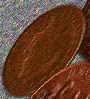

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 2/1107 — coins100_coin2.png


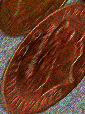

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 3/1107 — coins101_coin1.png


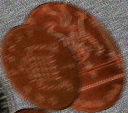

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 4/1107 — coins101_coin2.png


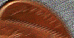

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 5/1107 — coins101_coin3.png


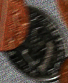

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 6/1107 — coins101_coin4.png


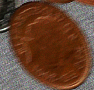

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 7/1107 — coins101_coin5.png


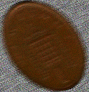

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 8/1107 — coins102_coin1.png


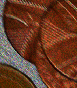

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 9/1107 — coins102_coin2.png


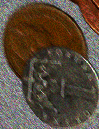

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 10/1107 — coins103_coin1.png


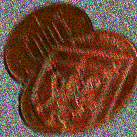

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 11/1107 — coins103_coin2.png


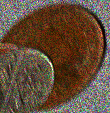

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 12/1107 — coins103_coin3.png


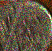

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 13/1107 — coins103_coin4.png


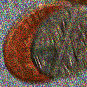

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 14/1107 — coins104_coin1.png


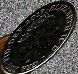

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 15/1107 — coins104_coin2.png


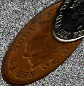

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 16/1107 — coins104_coin3.png


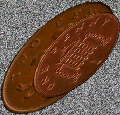

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 17/1107 — coins104_coin4.png


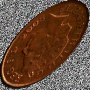

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 18/1107 — coins105_coin1.png


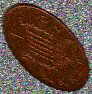

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 19/1107 — coins105_coin2.png


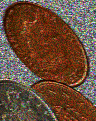

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 20/1107 — coins105_coin3.png


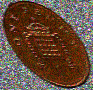

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 21/1107 — coins105_coin4.png


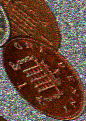

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 22/1107 — coins105_coin5.png


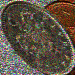

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 23/1107 — coins106_coin1.png


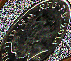

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 24/1107 — coins106_coin2.png


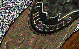

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 25/1107 — coins106_coin3.png


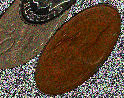

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 26/1107 — coins106_coin4.png


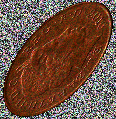

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 27/1107 — coins107_coin1.png


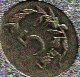

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 28/1107 — coins107_coin2.png


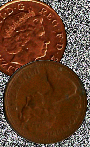

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 29/1107 — coins108_coin1.png


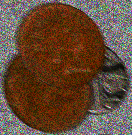

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 30/1107 — coins108_coin2.png


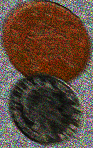

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 31/1107 — coins108_coin3.png


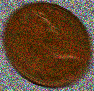

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 32/1107 — coins108_coin4.png


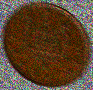

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 33/1107 — coins109_coin1.png


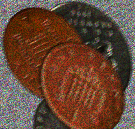

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 34/1107 — coins109_coin2.png


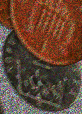

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 35/1107 — coins109_coin3.png


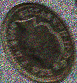

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 36/1107 — coins10_coin1.png


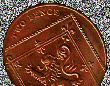

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 37/1107 — coins10_coin2.png


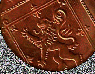

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 38/1107 — coins10_coin3.png


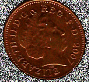

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 39/1107 — coins110_coin1.png


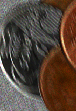

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 40/1107 — coins110_coin2.png


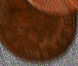

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 41/1107 — coins110_coin3.png


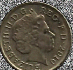

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 42/1107 — coins111_coin1.png


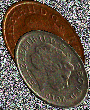

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 43/1107 — coins112_coin1.png


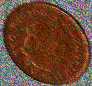

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 44/1107 — coins112_coin2.png


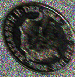

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 45/1107 — coins112_coin3.png


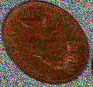

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 46/1107 — coins112_coin4.png


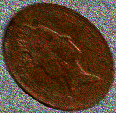

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 47/1107 — coins112_coin5.png


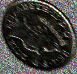

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 48/1107 — coins112_coin6.png


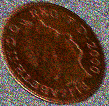

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 49/1107 — coins113_coin1.png


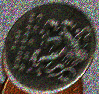

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 50/1107 — coins113_coin2.png


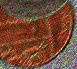

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 51/1107 — coins113_coin3.png


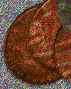

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 52/1107 — coins114_coin1.png


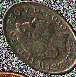

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 53/1107 — coins114_coin2.png


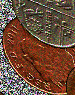

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 54/1107 — coins114_coin3.png


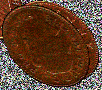

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 55/1107 — coins114_coin4.png


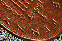

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 56/1107 — coins115_coin1.png


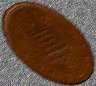

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 57/1107 — coins116_coin1.png


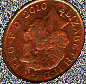

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 58/1107 — coins116_coin2.png


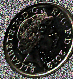

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 59/1107 — coins116_coin3.png


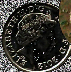

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 60/1107 — coins117_coin1.png


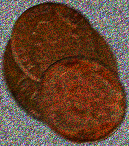

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 61/1107 — coins117_coin2.png


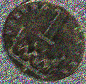

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 62/1107 — coins118_coin1.png


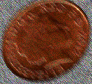

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 63/1107 — coins118_coin2.png


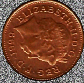

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 64/1107 — coins119_coin1.png


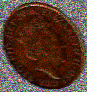

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 65/1107 — coins119_coin2.png


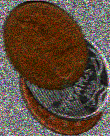

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 66/1107 — coins119_coin3.png


👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 67/1107 — coins11_coin1.png


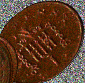

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 68/1107 — coins11_coin2.png


👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 69/1107 — coins11_coin3.png


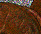

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 70/1107 — coins120_coin1.png


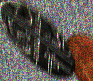

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 71/1107 — coins120_coin2.png


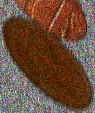

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 72/1107 — coins121_coin1.png


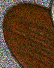

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 73/1107 — coins121_coin2.png


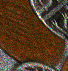

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 74/1107 — coins121_coin3.png


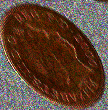

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 75/1107 — coins122_coin1.png


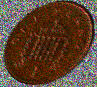

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 76/1107 — coins122_coin2.png


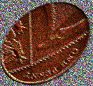

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 77/1107 — coins122_coin3.png


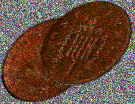

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 78/1107 — coins123_coin1.png


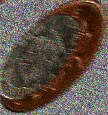

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 79/1107 — coins123_coin2.png


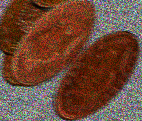

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 80/1107 — coins123_coin3.png


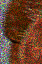

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 81/1107 — coins125_coin1.png


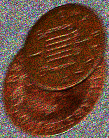

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 82/1107 — coins125_coin2.png


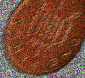

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 83/1107 — coins126_coin1.png


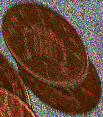

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 84/1107 — coins126_coin2.png


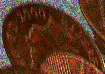

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 85/1107 — coins127_coin1.png


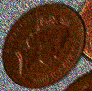

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 86/1107 — coins127_coin2.png


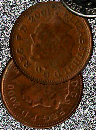

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 87/1107 — coins128_coin1.png


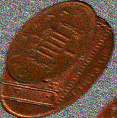

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 88/1107 — coins128_coin2.png


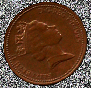

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 89/1107 — coins129_coin1.png


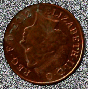

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 90/1107 — coins12_coin1.png


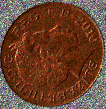

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 91/1107 — coins12_coin2.png


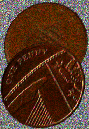

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 92/1107 — coins130_coin1.png


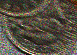

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 93/1107 — coins131_coin1.png


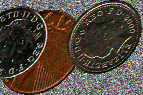

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 94/1107 — coins131_coin2.png


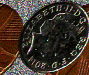

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 95/1107 — coins131_coin3.png


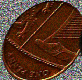

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 96/1107 — coins131_coin4.png


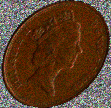

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 97/1107 — coins132_coin1.png


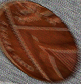

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 98/1107 — coins132_coin2.png


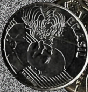

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 99/1107 — coins133_coin1.png


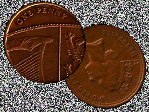

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 100/1107 — coins133_coin2.png


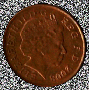

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 101/1107 — coins134_coin1.png


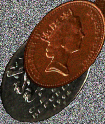

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 102/1107 — coins134_coin2.png


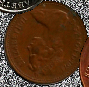

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 103/1107 — coins134_coin3.png


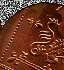

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 104/1107 — coins134_coin4.png


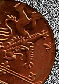

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 105/1107 — coins134_coin5.png


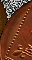

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 106/1107 — coins134_coin6.png


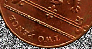

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 107/1107 — coins135_coin1.png


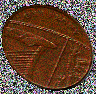

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 108/1107 — coins135_coin2.png


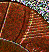

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 109/1107 — coins135_coin3.png


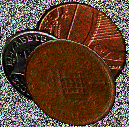

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 110/1107 — coins136_coin1.png


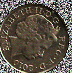

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 111/1107 — coins136_coin2.png


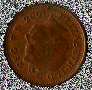

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 112/1107 — coins136_coin3.png


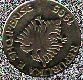

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 113/1107 — coins137_coin1.png


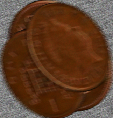

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 114/1107 — coins137_coin2.png


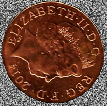

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 115/1107 — coins138_coin1.png


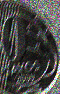

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 116/1107 — coins138_coin2.png


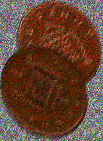

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 117/1107 — coins138_coin3.png


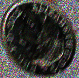

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 118/1107 — coins139_coin1.png


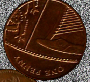

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 119/1107 — coins139_coin2.png


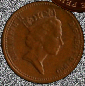

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 120/1107 — coins139_coin3.png


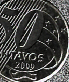

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 121/1107 — coins13_coin1.png


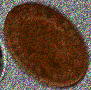

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 122/1107 — coins13_coin2.png


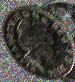

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 123/1107 — coins13_coin3.png


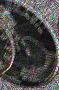

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 124/1107 — coins140_coin1.png


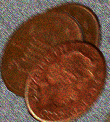

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 125/1107 — coins140_coin2.png


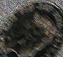

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 126/1107 — coins140_coin3.png


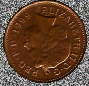

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 127/1107 — coins140_coin4.png


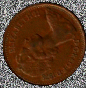

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 128/1107 — coins141_coin1.png


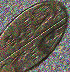

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 129/1107 — coins141_coin2.png


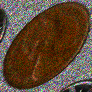

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 130/1107 — coins141_coin3.png


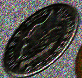

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 131/1107 — coins141_coin4.png


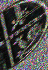

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 132/1107 — coins141_coin5.png


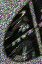

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 133/1107 — coins142_coin1.png


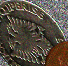

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 134/1107 — coins143_coin1.png


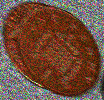

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 135/1107 — coins143_coin2.png


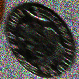

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 136/1107 — coins143_coin3.png


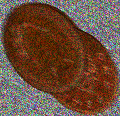

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 137/1107 — coins144_coin1.png


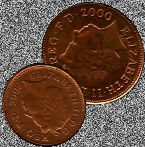

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 138/1107 — coins145_coin1.png


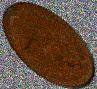

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 139/1107 — coins145_coin2.png


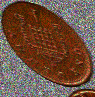

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 140/1107 — coins145_coin3.png


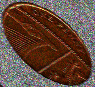

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 141/1107 — coins145_coin4.png


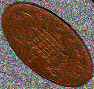

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 142/1107 — coins146_coin1.png


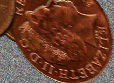

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 143/1107 — coins147_coin1.png


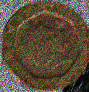

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 144/1107 — coins147_coin2.png


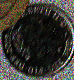

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 145/1107 — coins147_coin3.png


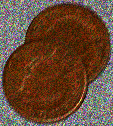

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 146/1107 — coins148_coin1.png


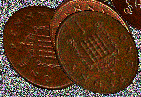

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 147/1107 — coins148_coin2.png


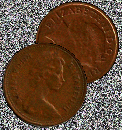

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 148/1107 — coins149_coin1.png


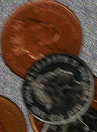

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 149/1107 — coins149_coin2.png


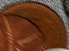

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 150/1107 — coins149_coin3.png


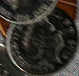

👉 Label as (heads / tails / skip / back / quit): heads

🪙 Coin 151/1107 — coins149_coin4.png


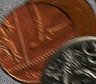

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 152/1107 — coins149_coin5.png


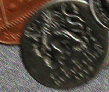

👉 Label as (heads / tails / skip / back / quit): tails

🪙 Coin 153/1107 — coins14_coin1.png


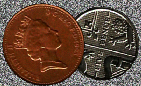

👉 Label as (heads / tails / skip / back / quit): skip

🪙 Coin 154/1107 — coins150_coin1.png


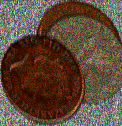

👉 Label as (heads / tails / skip / back / quit): quit
✅ Labels saved to coin_heads_labels.csv


In [13]:
import os
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd

coin_folder = "/content/cropped_coins"
coin_images = sorted([f for f in os.listdir(coin_folder) if f.endswith(".png")])
labels = []
i = 0

while i < len(coin_images) and len(labels) < 150:
    filename = coin_images[i]
    path = os.path.join(coin_folder, filename)
    img = cv2.imread(path)

    print(f"\nCoin {i+1}/{len(coin_images)} — {filename}")
    cv2_imshow(img)

    label = input("Label as (heads / tails / skip / back / quit): ").strip().lower()

    if label == "skip":
        i += 1
        continue
    elif label == "back" and i > 0:
        i -= 1
        labels = labels[:-1]
        continue
    elif label == "quit":
        break
    elif label in ["heads", "tails"]:
        labels.append({"filename": filename, "label": label})
        i += 1
    else:
        print("Invalid input. Please type 'heads', 'tails', 'skip', 'back', or 'quit'.")

# Save to CSV
df_labels = pd.DataFrame(labels)
df_labels.to_csv("/content/coin_heads_labels.csv", index=False)
print("Labels saved to coin_heads_labels.csv")


In [15]:
!pip install -q tensorflow

In [16]:
import os
import pandas as pd
import shutil
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# paths
labels_csv = "/content/coin_heads_labels.csv"
image_folder = "/content/cropped_coins"
base_dir = "/content/heads_tails_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# load labels
df = pd.read_csv(labels_csv)

# prepare train & val Split 80% train, 20% val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# create folder structure
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

for subset_dir in [train_dir, val_dir]:
    os.makedirs(os.path.join(subset_dir, "heads"))
    os.makedirs(os.path.join(subset_dir, "tails"))

# function to copy each img
# to the correct class subfolder
def copy_images(df_subset, target_dir):
    for _, row in df_subset.iterrows():
        src = os.path.join(image_folder, row["filename"])
        dst = os.path.join(target_dir, row["label"], row["filename"])
        if os.path.exists(src):
            shutil.copy(src, dst)

copy_images(train_df, train_dir)
copy_images(val_df, val_dir)

# image generators
img_size = (96, 96)
batch_size = 16

# apply data augmentation for train
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True).flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

# build CNN model
# load MobileNetV2, pretrained on ImageNet dataset
# remove original output layer
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
# freeze the base
base_model.trainable = False

model = models.Sequential([
    base_model,
    # flatten
    layers.GlobalAveragePooling2D(),
    # hidden layer
    layers.Dense(64, activation='relu'),
    # to prevent overfitting
    layers.Dropout(0.3),
    # binary classification
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# save model
model.save("/content/coin_heads_tails_model.h5")
print("✅ Model saved as coin_heads_tails_model.h5")

Found 75 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.5431 - loss: 0.9066 - val_accuracy: 0.6842 - val_loss: 0.5954
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7510 - loss: 0.5753 - val_accuracy: 0.6842 - val_loss: 0.5673
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6863 - loss: 0.5957 - val_accuracy: 0.7895 - val_loss: 0.5590
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.7946 - loss: 0.4570 - val_accuracy: 0.7368 - val_loss: 0.4562
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.8709 - loss: 0.2794 - val_accuracy: 0.6842 - val_loss: 0.4620
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8753 - loss: 0.3383 - val_accuracy: 0.7368 - val_loss: 0.4545
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9822 - loss: 0.1794 - val_accuracy: 0.7368 - val_loss: 0.4849
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8662 - loss: 0.2690 - val_accuracy: 0.6842 - val_loss: 0.5342
Ep

✅ Model saved as coin_heads_tails_model.h5


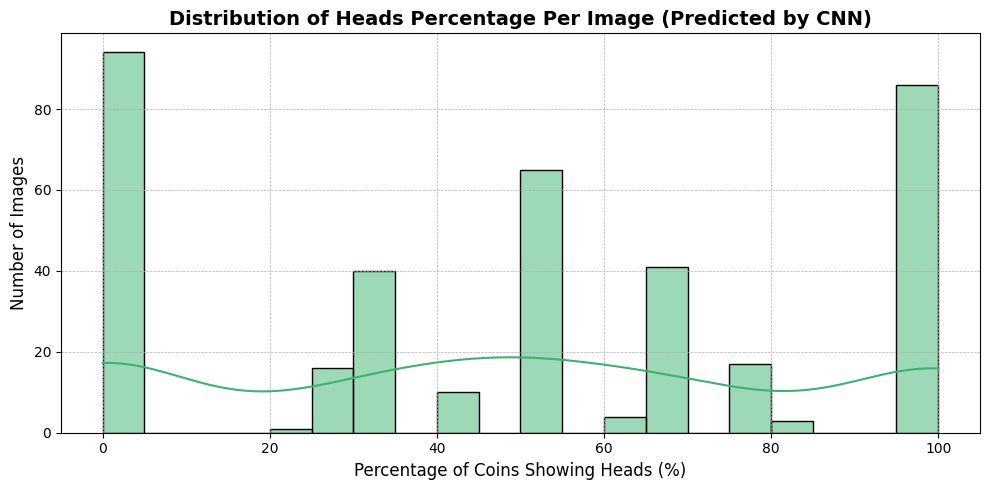

In [8]:
from tensorflow.keras.models import load_model
model_path = "/content/coin_heads_tails_model.h5"
image_folder = "/content/cropped_coins"
labels_csv = "/content/coin_heads_labels.csv"

# load Model & labels
model = load_model(model_path)
df_labels = pd.read_csv(labels_csv)
labeled_files = set(df_labels["filename"])

# get all cropped coins not in labeled set (unlabeled = test set)
all_coin_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
unlabeled_files = [f for f in all_coin_files if f not in labeled_files]

# create a dictionary to store results
image_heads_map = defaultdict(lambda: {"heads": 0, "total": 0})

# predict on each cropped, unlabeled coin
for filename in unlabeled_files:
    path = os.path.join(image_folder, filename)
    img = cv2.imread(path)
    if img is None:
        continue

    # preprocess image
    img_resized = cv2.resize(img, (96, 96))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)

    # predict heads or tails
    pred = model.predict(img_input, verbose=0)[0][0]
    label = "heads" if pred >= 0.5 else "tails"

    # group by original image name
    #  update total coin count & heads count for that image
    image_name = filename.split("_coin")[0] + ".png"
    image_heads_map[image_name]["total"] += 1
    if label == "heads":
        image_heads_map[image_name]["heads"] += 1


results = []
# loop through each image
for image_name, counts in image_heads_map.items():
  # calculate % of heads coins:
    percentage = (counts["heads"] / counts["total"]) * 100 if counts["total"] > 0 else 0
    # store results
    results.append({"image": image_name, "heads_percentage": percentage})

# convert to DataFrame
df_heads_predicted = pd.DataFrame(results)

# plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_heads_predicted["heads_percentage"], bins=20, kde=True, color="mediumseagreen", edgecolor="black")
plt.title("Distribution of Heads Percentage Per Image", fontsize=14, fontweight="bold")
plt.xlabel("Percentage of Coins Showing Heads (%)", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [19]:
df_heads_predicted.to_csv("/content/predicted_heads_percentages.csv", index=False)

In [3]:
#load model
import pandas as pd
from tensorflow.keras.models import load_model
model = load_model("coin_heads_tails_model.h5")
df_labels = pd.read_csv("coin_heads_labels.csv")